This notebook is to have timing tests for different functions of the package based on the timeit magic in notebooks.

In [90]:
# Import packages
import re
import ocel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import normalize
import ocel_features.algorithm as algo
import ocel_features.util.object_descendants as od
import ocel_features.util.object_graph as og
import ocel_features.variants.object_based as ob


# Constants
LOG_FOLDER='../logs/'
# Import logs
minimal = ocel.import_log(f'{LOG_FOLDER}actual-min.jsonocel')

# please download these logs from http://ocel-standard.org/ ie. from your log folder:
# small: wget http://ocel-standard.org/1.0/running-example.jsonocel.zip && unzip running-example.jsonocel.zip && rm running-example.jsonocel.zip
# medium: wget http://ocel-standard.org/1.0/p2p.jsonocel.zip && unzip p2p.jsonocel.zip && rm p2p.jsonocel.zip
# large: wget http://ocel-standard.org/1.0/o2c.jsonocel.zip && unzip o2c.jsonocel.zip && rm o2c.jsonocel.zip

small = ocel.import_log(f'{LOG_FOLDER}running-example.jsonocel')  # 22367 events, 11522 objects
medium = ocel.import_log(f'{LOG_FOLDER}p2p.jsonocel')  # 24854 events, 74489 objects -> includes multiple representations of same object
large = ocel.import_log(f'{LOG_FOLDER}o2c.jsonocel')  # 98350 events, 107767 objects

logs = [minimal, small, medium, large]

# Select the target log for the notebook
TARGET_LOG = small
# Define Features to check (None = all)
FEATURE_LIST = None# ['neighbour_count']

**Generate all features from target log**

In [91]:
# Apply the algorithm on all object types and all features
df, row_ids = algo.apply(TARGET_LOG, feature_list=FEATURE_LIST)

# drop OHE columns
df = df.loc[:, [x for x in df.columns if ':activity:' not in x]]

# Define a dictionary to show which indexes belong to which object type
object_types = TARGET_LOG['ocel:global-log']['ocel:object-types']

obj_type_index = {o_t: [] for o_t in object_types}
for i, obj in enumerate(row_ids):
    o_t = TARGET_LOG['ocel:objects'][obj]['ocel:type']
    obj_type_index[o_t].append(i)
    

**For each feature, show the 1D distribution with mean and std. dev.**

(1 / 5) 1D Distribution based on Object-Type customers (17 objects)
neighbour_count:           mean=695.529, std.dev=50.627, min=613, max=778
lifetime:                  mean=36504286.529, std.dev=1976761.778, min=33151955.0, max=39833146.0
single_type_ratio:         mean=1.0, std.dev=0.0, min=1.0, max=1.0
avg_obj_event_interaction: mean=7.145, std.dev=0.124, min=6.927, max=7.322


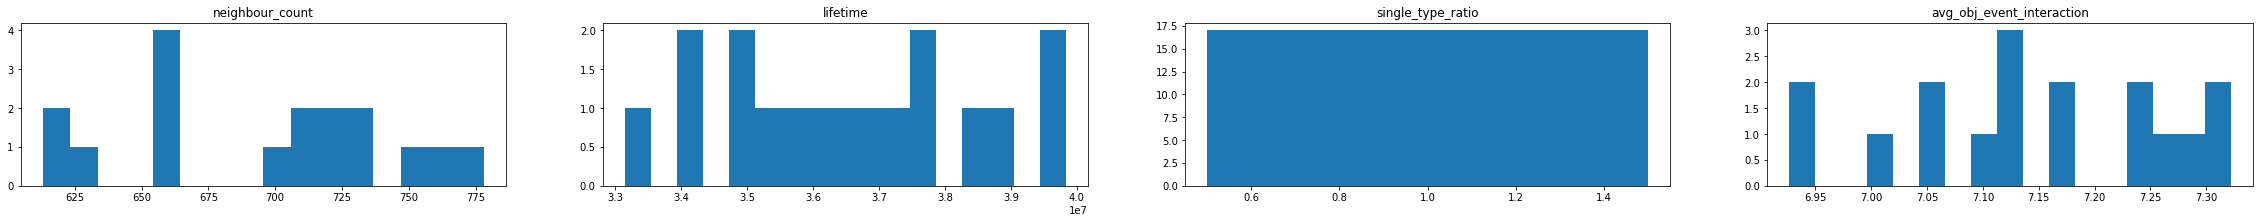

(2 / 5) 1D Distribution based on Object-Type items (8159 objects)
neighbour_count:           mean=23.569, std.dev=7.741, min=4, max=56
lifetime:                  mean=1313667.671, std.dev=1097801.396, min=43780.0, max=9909242.0
single_type_ratio:         mean=0.18, std.dev=0.098, min=0.077, max=1.0
avg_obj_event_interaction: mean=13.079, std.dev=4.054, min=3.333, max=27.857


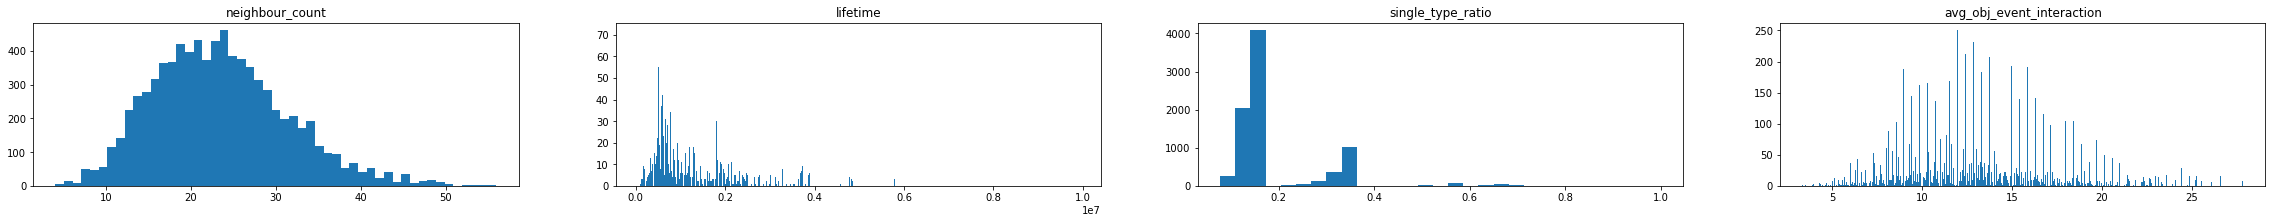

(3 / 5) 1D Distribution based on Object-Type orders (2000 objects)
neighbour_count:           mean=35.387, std.dev=15.743, min=4, max=104
lifetime:                  mean=1678100.212, std.dev=1172199.059, min=144039.0, max=9909242.0
single_type_ratio:         mean=0.575, std.dev=0.095, min=0.333, max=1.0
avg_obj_event_interaction: mean=10.824, std.dev=2.719, min=3.333, max=24.25


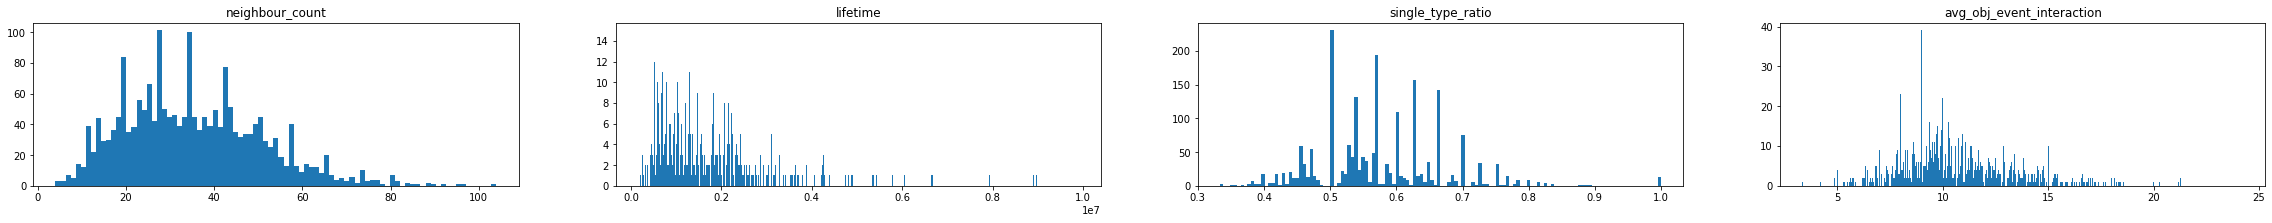

(4 / 5) 1D Distribution based on Object-Type packages (1325 objects)
neighbour_count:           mean=15.669, std.dev=7.174, min=4, max=45
lifetime:                  mean=156194.718, std.dev=127237.763, min=307.0, max=934993.0
single_type_ratio:         mean=1.0, std.dev=0.0, min=1.0, max=1.0
avg_obj_event_interaction: mean=15.669, std.dev=7.174, min=4.0, max=45.0


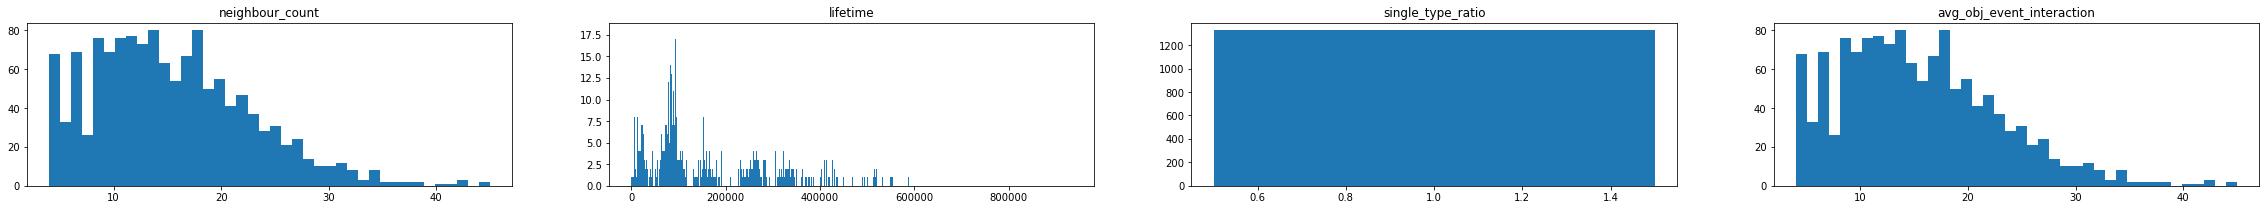

(5 / 5) 1D Distribution based on Object-Type products (20 objects)
neighbour_count:           mean=4721.95, std.dev=205.592, min=4287, max=5083
lifetime:                  mean=36810777.25, std.dev=1981548.226, min=33460778.0, max=40000090.0
single_type_ratio:         mean=0.209, std.dev=0.006, min=0.198, max=0.219
avg_obj_event_interaction: mean=12.335, std.dev=0.145, min=12.057, max=12.584


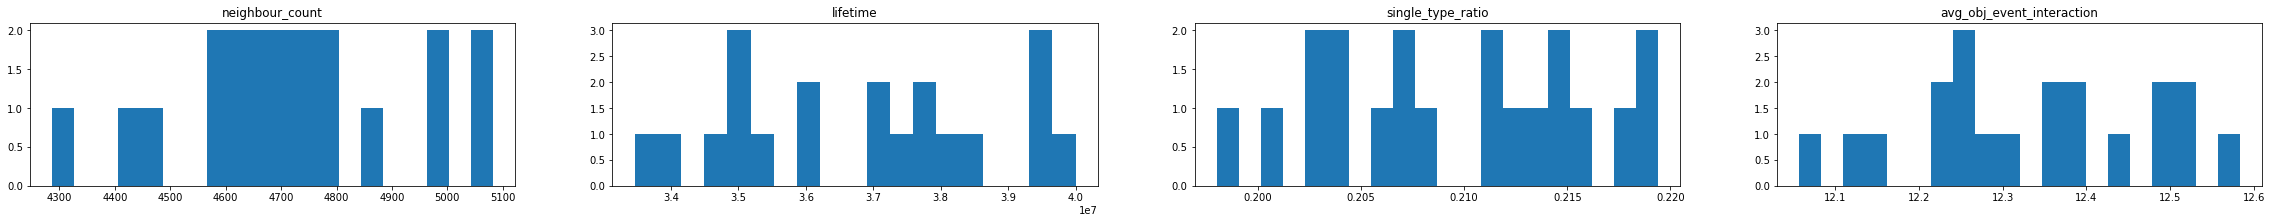

==========================================================DONE


In [92]:
# Prepare the descendant graphs
plt.rcParams['figure.figsize'] = (40,3)
for i, index in enumerate(obj_type_index):
    print('==========================================================')
    print(f'({i + 1} / {len(obj_type_index)}) 1D Distribution based on Object-Type {index} ({len(obj_type_index[index])} objects)')
    longest_feature_string = max([len(f) for f in df.columns])
    fig, axs = plt.subplots(1, len(df.columns))
    for j, feature in enumerate(df.columns):
        hist_x = df.iloc[obj_type_index[index], j].values
        if len(df.columns) > 1:
            axs[j].title.set_text(f'{feature[4:]}')
            axs[j].hist(hist_x, bins=len({x for x in hist_x}))
        else:
            axs.title.set_text(f'{feature[4:]}')
            axs.hist(hist_x, bins=len({x for x in hist_x}))
        s = pd.Series(data= hist_x)
        info_string = f'mean={round(s.mean(), 3)}, std.dev={round(s.std(), 3)}, min={round(s.min(), 3)}, max={round(s.max(), 3)}'
        print(f'{feature[4:]}: {" " * (longest_feature_string - len(feature))}{info_string}')
    plt.show()

print('==========================================================DONE')

**Compare Feature Distributions among object types (object types with 0 variance in a feature will be skipped)**
- x axis limited to 2 std. dev

Comparing the distributions of the features between object types


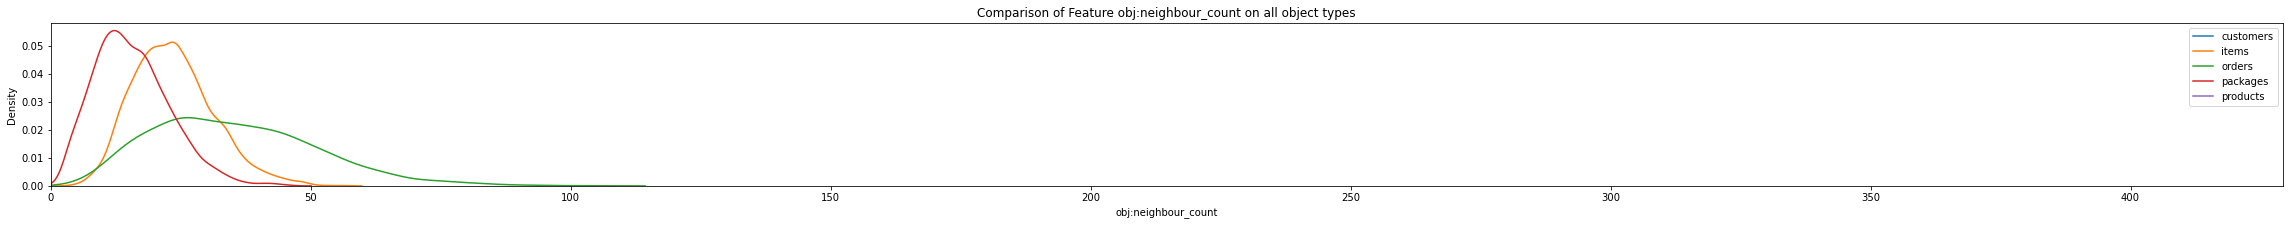

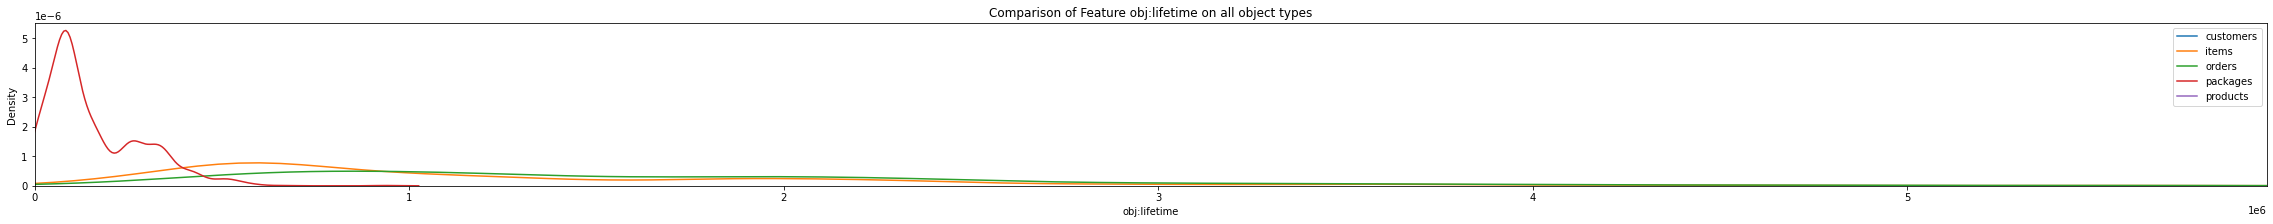

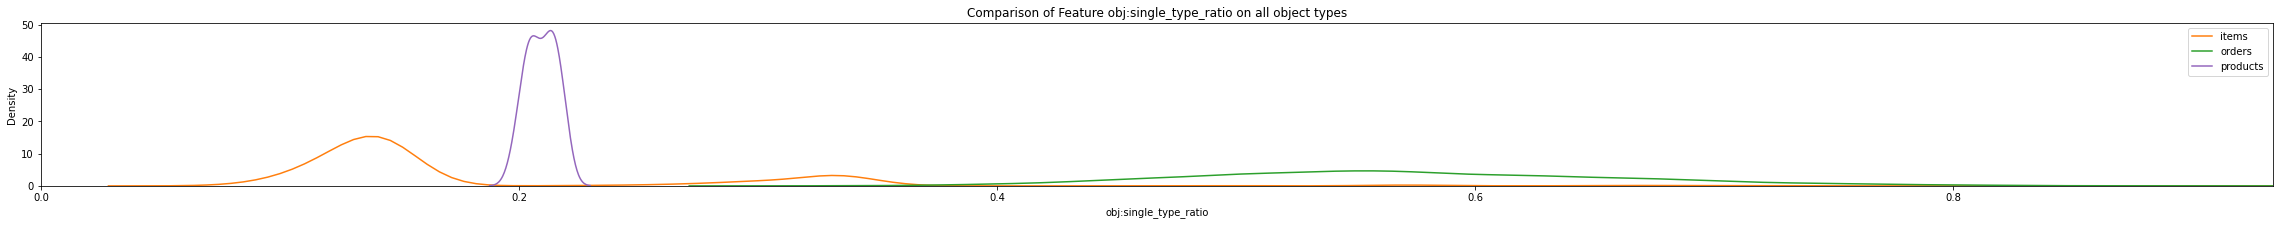

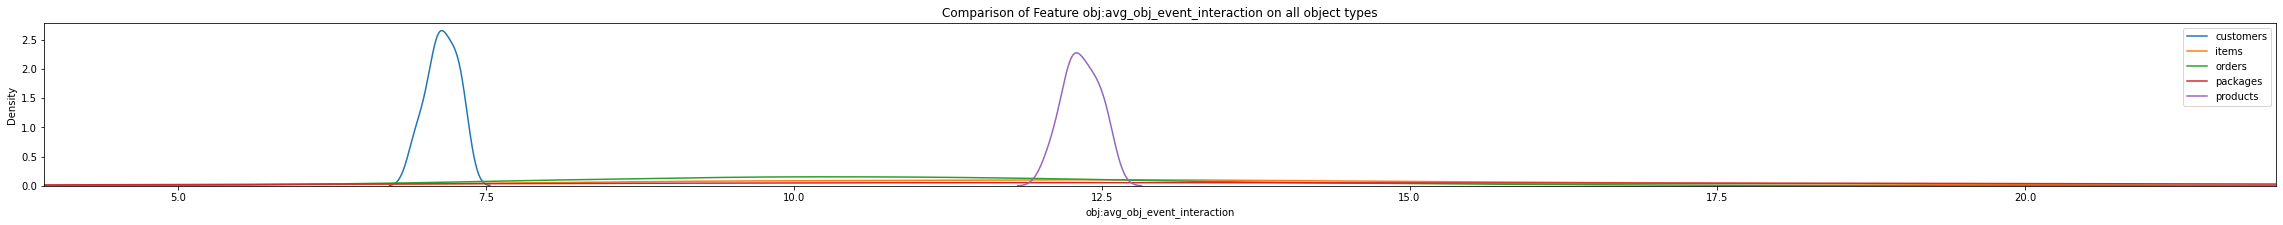

==========================================================DONE


In [93]:
print('Comparing the distributions of the features between object types')

for i, feature in enumerate(df.columns):
    print('==========================================================')
    fig, axs = plt.subplots()
    s = []
    for j, index in enumerate(obj_type_index):
        data_x = df.iloc[obj_type_index[index], i].values
        s.extend(data_x)
        sns.kdeplot(data_x, label=index, warn_singular=False)#, bw_adjust=0.5)
    plt.title(f'Comparison of Feature {feature} on all object types')
    plt.xlabel(f'{feature}')
    s = pd.Series(data=s)
    bot = max(s.mean() - (2*s.std()), 0)
    top = s.mean() + (2*s.std())
    plt.legend()
    plt.xlim((bot, top))
    plt.show()
    
print('==========================================================DONE')

**Features pairwise comparisons**